In [10]:
import pandas as pd
import geopandas as gpd
import numpy as np

from datetime import datetime

In [7]:
file_path = "C:/Msc/research progress/Codes/dates_22.txt"
with open(file_path, "r") as file:
    contents = file.readlines()
    

In [8]:
# Remove any leading or trailing whitespace from each line
extracted_dates = [line.strip() for line in contents]
extracted_dates

['2022-03-01',
 '2022-03-21',
 '2022-04-10',
 '2022-04-30',
 '2022-05-20',
 '2022-06-09',
 '2022-06-29',
 '2022-07-19',
 '2022-08-08',
 '2022-08-28',
 '2022-09-17',
 '2022-10-07',
 '2022-10-27']

In [11]:
import os
import rasterio as rio
from tqdm import tqdm
root = r"D:\MSC_data\CROP MAPPING\2022_temporal\2o_day_median"

tifs = os.listdir(root)
# Remove any non-TIFF files from the list
tifs = [file for file in tifs if file.endswith('.tif')]
tifs_sorted = sorted(tifs, key=lambda x: int(os.path.splitext(x)[0]))
images_df = pd.DataFrame(tifs_sorted, columns=["filename"])
images_df["date"] = extracted_dates
timeseries, dates = [], []
for tif, date in tqdm(zip(images_df.filename, images_df.date), desc="stacking tif images"):
    with rio.open(os.path.join(root, tif), "r") as src:
        img = src.read()
        # print("Image shape:", img.shape)
        transform = src.transform
        crs = src.crs
        if img.shape[0] == 9:
            timeseries.append(img)
            dates.append(datetime.strptime(date, "%Y-%m-%d"))
timeseries = np.stack(timeseries)             


stacking tif images: 13it [00:13,  1.05s/it]


In [12]:
np.savez("kitale2022.npz", 
         timeseries=timeseries,
         dates=dates,
         transform=transform,
         crs=str(crs))

In [13]:
npzfile = np.load("kitale2022.npz", allow_pickle=True)
timeseries = npzfile["timeseries"]
dates = npzfile["dates"]
transform = npzfile["transform"]
crs = npzfile["crs"]

In [8]:
print(f"T x D x H x W: {timeseries.shape}")

T x D x H x W: (13, 9, 1345, 1663)


In [14]:
transform

array([ 8.98315284e-05,  0.00000000e+00,  3.48075613e+01,  0.00000000e+00,
       -8.98315284e-05,  1.11966017e+00,  0.00000000e+00,  0.00000000e+00,
        1.00000000e+00])

In [121]:
crs

array('EPSG:32636', dtype='<U10')

In [15]:
index = 2

single_image = timeseries[index]
single_image.shape

(9, 1345, 1663)

In [2]:
bands = ["B2",  # blue
         "B3",  # green
         "B4",  # red
         "B11",
         "B8", 
         "ndvi",
         "evi",
         "ndmi",
         "msavi" 
         ]

In [16]:
rgb_bands = ["B4", "B3", "B2"]

rgb_image = single_image[np.array([bands.index(b) for b in rgb_bands])]

rgb_image.shape

(3, 1345, 1663)

In [17]:
# plotting
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

plt.rc("axes.spines", top=False, right=False)

In [ ]:
#plot a single image
timeindex = 7
image = timeseries[timeindex]
date = dates[timeindex]

fig, ax = plt.subplots(figsize=(8,8))
rgb = np.nan_to_num(rgb_image).transpose(1,2,0)
ax.imshow((rgb-np.percentile(rgb, 2, axis=(0,1)))/(np.percentile(rgb, 98, axis=(0,1))-np.percentile(rgb, 2, axis=(0,1))))
ax.set_title(f"True Color: Red-Green-Blue ({date.strftime('%Y-%m-%d')})")
ax.axis("off")

In [23]:
# interactive cells
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

timeindex = 2

@interact(bandred=bands, bandgreen=bands, bandblue=bands)
def plot_image(bandred="B4", bandgreen="B3", bandblue="B2"):
  fig, ax = plt.subplots(figsize=(8,8))
  rgb = np.nan_to_num(timeseries[timeindex, np.array([bands.index(b) for b in [bandred, bandgreen, bandblue]])]).transpose(1,2,0)
  ax.imshow((rgb-np.percentile(rgb, 2, axis=(0,1)))/(np.percentile(rgb, 98, axis=(0,1))-np.percentile(rgb, 2, axis=(0,1))))
  ax.set_title(f"bands: {bandred}-{bandgreen}-{bandblue}")
  ax.axis("off")

interactive(children=(Dropdown(description='bandred', index=2, options=('B2', 'B3', 'B4', 'B11', 'B8', 'ndvi',…

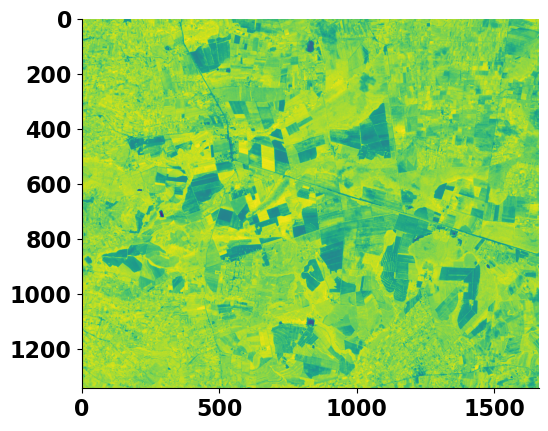

In [22]:
idx = 4
ndvi_band_index = bands.index("ndmi")
ndvi = timeseries[idx, ndvi_band_index]
plt.imshow(ndvi)

In [20]:
ndvi_band_index = bands.index("ndvi")
ndvi_band = timeseries[:, ndvi_band_index]
print(ndvi_band.shape)

(13, 1345, 1663)


In [15]:
gdf = gpd.read_file(r"C:\Msc\research progress\Data collection\ADC data\ODK\G_N_Merge_sel_sel.shp")

,Name,PopupInfo,Crop_23,Crop_22,Crop_21,Crop_20,Id,Field_Name,geometry
0,F3,F3,Maize,Maize,Maize,Maize,0,NaN,"POLYGON Z ((34.88893 1.07938 0.00000, 34.88859..."
1,F4,F4,Maize,Maize,Maize,Maize,0,NaN,"POLYGON Z ((34.89459 1.08114 0.00000, 34.89817..."
2,F2,F2,Maize,Maize,Maize,Maize,0,NaN,"POLYGON Z ((34.88854 1.08335 0.00000, 34.89409..."
3,F1,F1,Maize,Maize,Maize,Maize,0,NaN,"POLYGON Z ((34.89432 1.08299 0.00000, 34.89568..."
4,F6,F6,Maize,Pasture,Pasture,Pasture,0,NaN,"POLYGON Z ((34.89189 1.07549 0.00000, 34.89265..."
...,...,...,...,...,...,...,...,...,...
173,NaN,NaN,Maize,Maize,Maize,NaN,0,NaN,"POLYGON Z ((34.90680 1.04276 0.00000, 34.90759..."
174,NaN,NaN,Sugarcane,Sugarcane,Sugarcane,NaN,0,NaN,"POLYGON Z ((34.85353 1.00476 0.00000, 34.85396..."
175,NaN,NaN,Sugarcane,Sugarcane,Sugarcane,NaN,0,NaN,"POLYGON Z ((34.84458 1.10847 0.00000, 34.84548..."
176,NaN,NaN,Sugarcane,Sugarcane,Sugarcane,NaN,0,NaN,"POLYGON Z ((34.84823 1.09918 0.00000, 34.84914..."


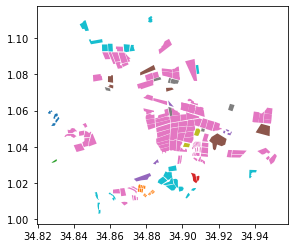

In [16]:
gdf.plot(column="Crop_22")
gdf

In [17]:
unique_crops = gdf['Crop_22'].unique()

# Create a mapping dictionary to assign IDs to each unique crop
crop_mapping = {crop: idx+1 for idx, crop in enumerate(unique_crops)}

# Function to map crop name to ID
def assign_id(row):
    crop = row['Crop_22']
    return crop_mapping.get(crop, 0)  # Assign ID based on mapping, 0 if crop not found

# Create a new column 'id' in the GeoDataFrame and assign unique IDs based on crop name
gdf['id'] = gdf.apply(assign_id, axis=1)

# Print the updated GeoDataFrame
# print(gdf['id'].tolist())
# id_factor = pd.Series(gdf['id'], dtype='category')

# # Print the factor
# print(id_factor)

In [35]:
import rasterio as rio
ds = rio.open(r"C:\Users\KIMELI\Documents\Downloads\20220426T074621_20220426T075217_T36NXG.tif")
ds.transform

Affine(10.0, 0.0, 701140.0,
       0.0, -10.0, 123830.0)

In [22]:
gdf["ID"] = gdf.reset_index()["index"]
# gdf = gdf.to_crs("EPSG:4326")
gdf

,Name,PopupInfo,Crop_23,Crop_22,Crop_21,Crop_20,Id,Field_Name,geometry,id,ID
0,F3,F3,Maize,Maize,Maize,Maize,0,NaN,"POLYGON Z ((34.88893 1.07938 0.00000, 34.88859...",1,0
1,F4,F4,Maize,Maize,Maize,Maize,0,NaN,"POLYGON Z ((34.89459 1.08114 0.00000, 34.89817...",1,1
2,F2,F2,Maize,Maize,Maize,Maize,0,NaN,"POLYGON Z ((34.88854 1.08335 0.00000, 34.89409...",1,2
3,F1,F1,Maize,Maize,Maize,Maize,0,NaN,"POLYGON Z ((34.89432 1.08299 0.00000, 34.89568...",1,3
4,F6,F6,Maize,Pasture,Pasture,Pasture,0,NaN,"POLYGON Z ((34.89189 1.07549 0.00000, 34.89265...",2,4
...,...,...,...,...,...,...,...,...,...,...,...
173,NaN,NaN,Maize,Maize,Maize,NaN,0,NaN,"POLYGON Z ((34.90680 1.04276 0.00000, 34.90759...",1,173
174,NaN,NaN,Sugarcane,Sugarcane,Sugarcane,NaN,0,NaN,"POLYGON Z ((34.85353 1.00476 0.00000, 34.85396...",4,174
175,NaN,NaN,Sugarcane,Sugarcane,Sugarcane,NaN,0,NaN,"POLYGON Z ((34.84458 1.10847 0.00000, 34.84548...",4,175
176,NaN,NaN,Sugarcane,Sugarcane,Sugarcane,NaN,0,NaN,"POLYGON Z ((34.84823 1.09918 0.00000, 34.84914...",4,176


In [20]:
# vector and raster data
# import rasterio as rio
from rasterio.features import rasterize

In [18]:
# from osgeo import gdal
ds= rio.open(r"D:\MSC_data\CROP MAPPING\2022_temporal\2o_day_median\prj\prj_10.tif")
ds.transform
# bands = {ds.GetRasterBand(i).GetDescription(): i for i in range(1, ds.RasterCount + 1)}

Affine(9.973270879927345, 0.0, 701131.7357777869,
       0.0, -9.973270879927322, 123828.93796178786)

In [25]:
import matplotlib
import matplotlib.pyplot as plt

In [27]:
gdf.crs

<Compound CRS: COMPD_CS["WGS 84 + EGM96_Geoid",GEOGCS["WGS 84",DA ...>
Name: WGS 84 + EGM96_Geoid
Axis Info [ellipsoidal|vertical]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
- [up]: Gravity-related height (Meter)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
Sub CRS:
- WGS 84
- EGM96_Geoid

In [23]:
# transform =transform
transform= (9.973270879927345, 0.0, 701131.7357777869,0.0, -9.973270879927322, 123828.93796178786)
crs = "EPSG:32636"
# gdf = gdf.to_crs("EPSG:32636")
croptype_rasterized = rasterize(zip(gdf.to_crs(crs).geometry, gdf.id), out_shape=(1345,1663), transform=transform, fill=np.nan)
id_rasterized = rasterize(zip(gdf.to_crs(crs).geometry, gdf.ID), out_shape=(timeseries.shape[2],timeseries.shape[3]), transform=transform, fill=np.nan)

(-0.5, 1662.5, 1344.5, -0.5)

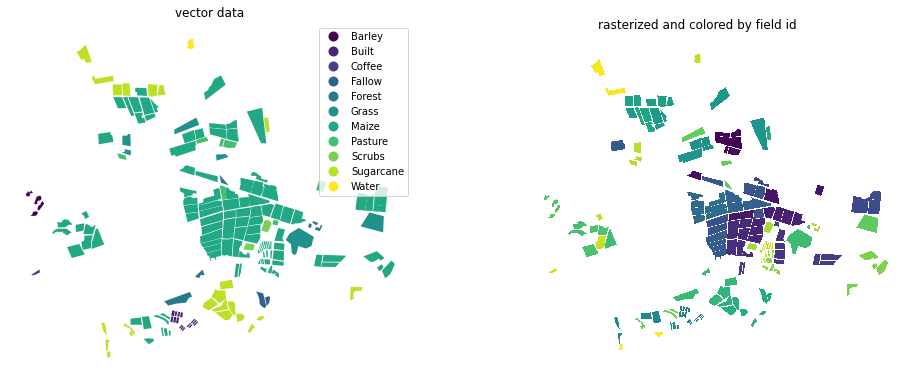

In [26]:
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("name", colors.color)

fig, axs = plt.subplots(1,2,figsize=(8*2,8))

ax = axs[0]
gdf.plot(column="Crop_22",cmap='viridis', ax=ax, legend=True)
ax.set_title("vector data")
ax.axis("off")

ax = axs[1]
ax.set_title("rasterized and colored by field id")
im = ax.imshow(id_rasterized, interpolation="none")
ax.axis("off")

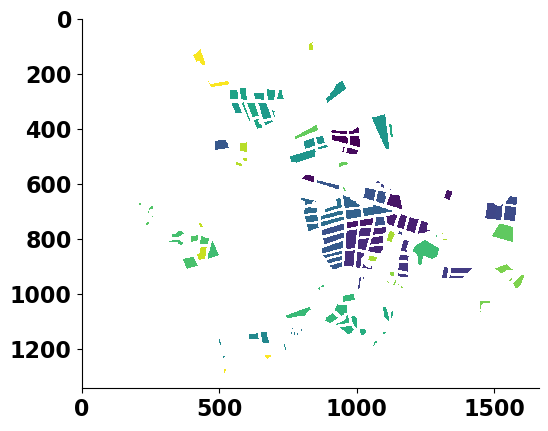

In [31]:
plt.figure()
plt.imshow(id_rasterized)

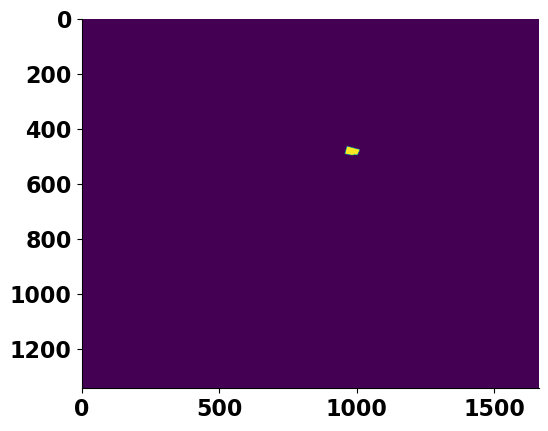

In [32]:
field_id = 5 # field id; try also 0,1,2,3,4
msk = id_rasterized==field_id
plt.figure()
plt.imshow(msk)

Text(0, 0.5, 'reflectance')

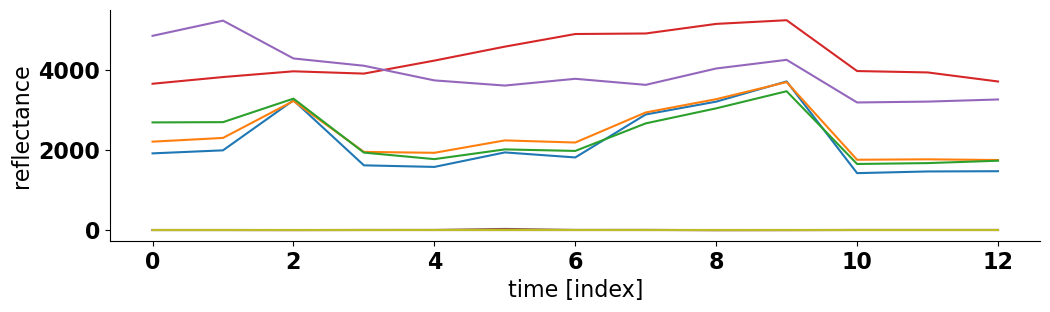

In [33]:
average_band_values = timeseries[:,:,msk].mean(-1)

plt.figure(figsize=(12,3))
plt.plot(average_band_values)
plt.xlabel("time [index]")
plt.ylabel("reflectance")

In [ ]:
!pip install scikit-image

In [36]:
from skimage.exposure import equalize_hist
#@title
# reflectance_bands = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12"]
reflectance_bands = bands
band_idxs = np.array([bands.index(b) for b in reflectance_bands])

@interact(field_id=gdf.ID.values, date=[d.strftime("%Y-%m-%d") for d in dates])
def plot_field(field_id=27, date="2022-08-28"):

  idx = list(dates).index(datetime.strptime(date, "%Y-%m-%d"))

  classname = gdf.loc[gdf.ID == field_id].Crop_22.values[0]

  fig, axs = plt.subplots(1,2,figsize=(8*2,8))

  # first row: images
  ax = axs[0]
  ax.set_title(f"selected {classname} field")
  im = ax.imshow(id_rasterized==field_id)
  ax.axis("off")

  ax = axs[1]
  ax.set_title(f"overlay of RGB at {date}")
  rgb = np.nan_to_num(timeseries[idx, np.array([bands.index(b) for b in ["B4", "B3", "B2"]])])
  ax.imshow(equalize_hist(rgb).transpose(1,2,0))
  im = ax.contour(id_rasterized==field_id)
  ax.axis("off")

  msk = id_rasterized==field_id
  average_band_values = timeseries[:,:,msk].mean(-1)
  averaged_time_series = average_band_values[:,band_idxs]


  nirred = np.nan_to_num(average_band_values[:, np.array([bands.index(b) for b in ["B8", "B4"]])])
  nir, red = nirred[:,0], nirred[:,1]
  ndvi = (nir - red) / (nir + red)

  # ndvi = timeseries[:, 8, :, :]

  # second row: time series plots
  fig, axs = plt.subplots(1,2,figsize=(8*2,3))

  ax = axs[0]
  ax.plot(dates, averaged_time_series * 1e-2)
  ticks = [datetime(year=2022, month=m, day=1) for m in [2,4,6,8,10,12]]
  ax.set_xticks(ticks)
  ax.set_xticklabels([t.strftime("%b") for t in ticks])
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='left')
  ax.axvline(dates[idx], linewidth=5, color="black")
  ax.set_ylabel("reflectance [0-100%]")

  ax = axs[1]
  ax.plot(dates, ndvi)
  ticks = [datetime(year=2022, month=m, day=1) for m in [2,4,6,8,10,12]]
  ax.set_xticks(ticks)
  ax.set_xticklabels([t.strftime("%b") for t in ticks])
  ax.set_ylabel("ndvi [0-1]")
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='left')
  ax.axvline(dates[idx], linewidth=5, color="black")


interactive(children=(Dropdown(description='field_id', index=27, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11…

In [37]:
#@title
reflectance_bands = bands
band_idxs = np.array([bands.index(b) for b in reflectance_bands])

@interact(classname1=gdf.Crop_22.unique(), classname2=gdf.Crop_22.unique(), date=[d.strftime("%Y-%m-%d") for d in dates])
def plot_class(classname1="Maize", classname2="Sugarcane", date="2022-08-28"):

  classid1 = gdf.loc[gdf.Crop_22 == classname1].iloc[0].id
  classid2 = gdf.loc[gdf.Crop_22 == classname2].iloc[0].id

  idx = list(dates).index(datetime.strptime(date, "%Y-%m-%d"))

  msk1 = croptype_rasterized==classid1
  msk2 = croptype_rasterized==classid2

  # color1 = colors.loc[colors.classname==classname1].color.values[0]
  # color2 = colors.loc[colors.classname==classname2].color.values[0]

  fig, axs = plt.subplots(2,1,figsize=(6,8), gridspec_kw={'height_ratios': [3,1]})

  ax = axs[0]
  ax.set_title(f"overlay of RGB at {date}")
  rgb = np.nan_to_num(timeseries[idx, np.array([bands.index(b) for b in ["B4", "B3", "B2"]])])
  ax.imshow(equalize_hist(rgb).transpose(1,2,0))
  im = ax.contour(msk1)
  im = ax.contour(msk2)
  ax.axis("off")

  IDS1 = gdf.loc[gdf.Crop_22==classname1].ID.values
  IDS2 = gdf.loc[gdf.Crop_22==classname2].ID.values

  def get_ndvi(IDS):
    ndvis = []
    for ID in IDS:
      msk = id_rasterized==ID
      average_band_values = timeseries[:,:,msk].mean(-1)
      averaged_time_series = average_band_values[:,band_idxs]

      nirred = np.nan_to_num(average_band_values[:, np.array([bands.index(b) for b in ["B8", "B4"]])])
      nir, red = nirred[:,0], nirred[:,1]
      ndvis.append((nir - red) / (nir + red))
    return np.stack(ndvis)

  ndvis1 = get_ndvi(IDS1)
  ndvis2 = get_ndvi(IDS2)

  ndvi_mean = ndvis1.mean(0)

  ax = axs[1]
  ax.fill_between(dates, ndvis1.mean(0) + ndvis1.std(0), ndvis1.mean(0) - ndvis1.std(0), alpha=0.5)
  ax.plot(dates, ndvis1.mean(0))

  ax.fill_between(dates, ndvis2.mean(0) + ndvis2.std(0), ndvis2.mean(0) - ndvis2.std(0), alpha=0.5)
  ax.plot(dates, ndvis2.mean(0))

  ticks = [datetime(year=2022, month=m, day=1) for m in [2,4,6,8,10,12]]
  ax.set_xticks(ticks)
  ax.set_xticklabels([t.strftime("%b") for t in ticks])
  ax.set_ylabel("ndvi [0-1]")
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='left')
  ax.axvline(dates[idx], linewidth=3)
  ax.legend([classname1, classname2], ncol=2, bbox_to_anchor=(0.65, 1.05))


interactive(children=(Dropdown(description='classname1', options=('Maize', 'Pasture', 'Built', 'Sugarcane', 'F…

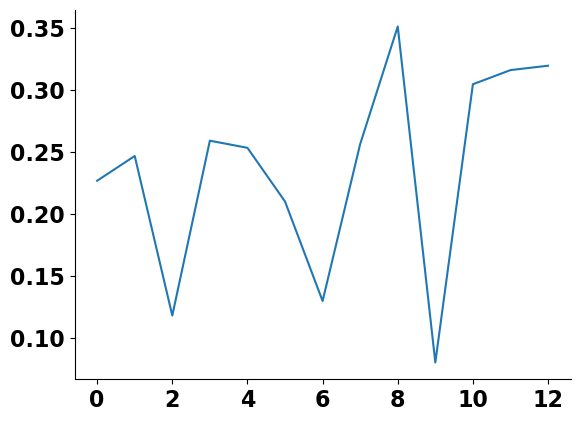

In [38]:
# calculate NDVI per field
def get_ndvi_timeseries(field_ids, timeseries):
    """"""
    ndvis = []
    for ID in field_ids:
      msk = id_rasterized==ID
      average_band_values = timeseries[:,:,msk].mean(-1)
      averaged_time_series = average_band_values[:,band_idxs]

      nirred = np.nan_to_num(average_band_values[:, np.array([bands.index(b) for b in ["B8", "B4"]])])
      nir, red = nirred[:,0], nirred[:,1]
      ndvis.append((nir - red) / (nir + red))
    return np.stack(ndvis)

field_id = 30
ndvi_timeseries_single_field = get_ndvi_timeseries([field_id], timeseries)
plt.plot(ndvi_timeseries_single_field.T)

In [39]:
features = ["max_ndvi", "mean_ndvi", "day_of_year_max_ndvi", "ndvi_area"]

In [88]:
import datetime

In [93]:
def feature_extraction(ndvi_timeseries):

  # calculate mean NDVI
  mean_ndvi = ndvi_timeseries.mean(1)
  
  # calculate max NDVI
  max_ndvi = ndvi_timeseries.max(1)
  
  # calculate day of max NDVI [index]
  argmax_ndvi = ndvi_timeseries.argmax(1)
    
  # datetime_dates = [datetime.datetime.strptime(date_str, "%Y-%m-%d") for date_str in dates]
  # convert argmax to day of year
  day_of_year_max_ndvi = [d.timetuple().tm_yday for d in np.array(dates)[argmax_ndvi]]
  
  # calculate area under the NDVI curve
  doys = [d.timetuple().tm_yday for d in np.array(dates)]
  ndvi_area = np.trapz(ndvi_timeseries, doys)
  return max_ndvi, mean_ndvi, day_of_year_max_ndvi, ndvi_area, doys

In [41]:
color = "#ff0000"

@interact(field_id=gdf.ID.values)
def plot_features(field_id=27):

  # feature extraction
  ndvi_timeseries_single_field = get_ndvi_timeseries([field_id], timeseries)
  max_ndvi, mean_ndvi, day_of_year_max_ndvi, ndvi_area, doys = feature_extraction(ndvi_timeseries_single_field)

  # plotting
  fig, ax = plt.subplots()
  ax.plot(ndvi_timeseries_single_field[0])
  ax.fill_between(np.arange(len(ndvi_timeseries_single_field.T)), ndvi_timeseries_single_field[0], alpha=0.2)
  ax.axhline(mean_ndvi, color="red")
  ax.axhline(max_ndvi, color="blue")
  ax.axvline(list(doys).index(day_of_year_max_ndvi[0]), color="black")
  ax.set_title(f"area {ndvi_area[0]:.0f}")

  print(f"mean ndvi {mean_ndvi[0]:.2f}; day of max ndvi {day_of_year_max_ndvi[0]}; ndvi area {ndvi_area[0]:.2f}")


interactive(children=(Dropdown(description='field_id', index=27, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11…

In [42]:
ndvi_timeseries_all_fields = get_ndvi_timeseries(gdf.ID.values, timeseries)
max_ndvi, mean_ndvi, day_of_year_max_ndvi, ndvi_area, doys = feature_extraction(ndvi_timeseries_all_fields)

# add features to geodataframe
gdf["max_ndvi"] = max_ndvi
gdf["mean_ndvi"] = mean_ndvi
gdf["day_of_year_max_ndvi"] = day_of_year_max_ndvi
gdf["ndvi_area"] = ndvi_area

gdf.head()

C:\Users\KIMELI\AppData\Local\Temp\ipykernel_12304\3113417295.py:7: RuntimeWarning: Mean of empty slice.
  average_band_values = timeseries[:,:,msk].mean(-1)
C:\Users\KIMELI\anaconda3\envs\geos\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\KIMELI\AppData\Local\Temp\ipykernel_12304\3113417295.py:12: RuntimeWarning: invalid value encountered in divide
  ndvis.append((nir - red) / (nir + red))


,Name,PopupInfo,Crop_23,Crop_22,Crop_21,Crop_20,Id,Field_Name,geometry,id,ID,max_ndvi,mean_ndvi,day_of_year_max_ndvi,ndvi_area
0,F3,F3,Maize,Maize,Maize,Maize,0,NaN,"POLYGON Z ((34.88893 1.07938 0.00000, 34.88859...",1,0,0.308820,0.213869,260,50.816774
1,F4,F4,Maize,Maize,Maize,Maize,0,NaN,"POLYGON Z ((34.89459 1.08114 0.00000, 34.89817...",1,1,0.300136,0.190312,180,44.765499
2,F2,F2,Maize,Maize,Maize,Maize,0,NaN,"POLYGON Z ((34.88854 1.08335 0.00000, 34.89409...",1,2,0.317925,0.232456,280,55.355513
3,F1,F1,Maize,Maize,Maize,Maize,0,NaN,"POLYGON Z ((34.89432 1.08299 0.00000, 34.89568...",1,3,0.315010,0.200286,260,47.108032
4,F6,F6,Maize,Pasture,Pasture,Pasture,0,NaN,"POLYGON Z ((34.89189 1.07549 0.00000, 34.89265...",2,4,0.348631,0.262769,260,62.026679


In [47]:
# machine learning
import sklearn.svm
from skimage.exposure import equalize_hist
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [74]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(gdf, test_size=0.5,random_state=0)

In [70]:
#                SVM
# X = train[features].values
# y = train["id"]
# X = imputer.fit_transform(X)

# svm = sklearn.svm.SVC(C=3)
# svm.fit(X_imputed,y)

# X_test = test[features].values
# y_test = test["id"]

# y_pred = svm.predict(X_test)

# print(classification_report(y_true=y_test, y_pred=y_pred, zero_division=0))

<Axes: >

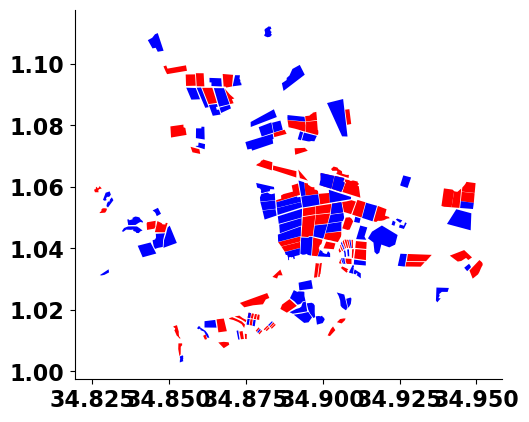

In [75]:
fig, ax = plt.subplots()
train.plot(ax=ax, color="red")
test.plot(ax=ax, color="blue")

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
X = train[features].values
y = train["id"]
X_test = test[features].values
y_test = test["id"]

In [80]:
from sklearn.impute import SimpleImputer

# Create an instance of SimpleImputer with the desired strategy
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform both training and test data
X_imputed = imputer.fit_transform(X)
X_test_imputed = imputer.transform(X_test)


In [81]:
# Drop rows with missing values in the training data
import numpy as np

# Drop rows with missing values in the training data
mask = np.isnan(X).any(axis=1)
X_dropped = X[~mask]
y_dropped = y[~mask]

# Drop rows with missing values in the test data
mask_test = np.isnan(X_test).any(axis=1)
X_test_dropped = X_test[~mask_test]
y_test_dropped = y_test[~mask_test]



In [82]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_dropped, y_dropped)

y_pred = rf.predict(X_test_dropped)

print(classification_report(y_true=y_test_dropped, y_pred=y_pred, zero_division=0))


              precision    recall  f1-score   support

           1       0.87      0.89      0.88        54
           2       0.00      0.00      0.00         5
           3       0.57      1.00      0.73         4
           4       0.41      0.82      0.55        11
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         3
           7       0.67      0.40      0.50         5
           8       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1

    accuracy                           0.72        88
   macro avg       0.25      0.31      0.27        88
weighted avg       0.65      0.72      0.67        88



In [ ]:
def feature_extraction(ndvi_timeseries):

  # calculate mean NDVI
  mean_ndvi = ndvi_timeseries.mean(1)
  
  # calculate max NDVI
  max_ndvi = ndvi_timeseries.max(1)
  
  # calculate day of max NDVI [index]
  argmax_ndvi = ndvi_timeseries.argmax(1)
    
  # datetime_dates = [datetime.datetime.strptime(date_str, "%Y-%m-%d") for date_str in dates]
  # convert argmax to day of year
  day_of_year_max_ndvi = [d.timetuple().tm_yday for d in np.array(dates)[argmax_ndvi]]
  
  # calculate area under the NDVI curve
  doys = [d.timetuple().tm_yday for d in np.array(dates)]
  ndvi_area = np.trapz(ndvi_timeseries, doys)
  return max_ndvi, mean_ndvi, day_of_year_max_ndvi, ndvi_area, doys

In [ ]:
# Preprocess the input time series data

# Extract features from the time series data
X_landcover = feature_extraction(timeseries)  # Replace 'extract_features' with your feature extraction process

# Apply the trained Random Forest model to make predictions
landcover_predictions = rf.predict(X_landcover)
